In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
import cv2
from numpy.ma import masked_array
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
import glob
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from StringIO import StringIO
import datetime
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
MetalFlag=0

In [3]:
path = "/data/OWN/Adicora/SF1/stable/output_00400"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,virial=True)
myhalo.r_virial(600)
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                           dtype=np.float32), myhalo.st.mass)


loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 223.624 kpc
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  9.879e+11 M_sun
| p_dm_200      =  8.559e+05 particles
| stellar mass  =  1.249e+11 M_sun
| p_st_200      =  5.266e+05 psrticles
| gas mass      =  1.211e+11 M_sun
| p_gs_200      =  1.810e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |20, 0, 0|
| D =| 0,17, 0|
|    | 0, 0, 1|


In [4]:
print "m_dm = {0:.3e}".format(myhalo.dm.total_m)
print "m_st = {0:.3e}".format(myhalo.st.total_m)


m_dm = 9.879e+11
m_st = 1.249e+11


In [5]:
cs2 = (0.666*(myhalo.gs.temp2 / myhalo.p.scale_T2 )) * myhalo.p.simutokms**2
cs2[np.where(cs2<=-0)]= 0.01
mach2 = myhalo.gs.sigma2/cs2 
myhalo.gs.M2 = mach2
myhalo.gs.cs2 = cs2
factG = 3. / 4. / 2. / np.pi * 0.3089 * myhalo.p.aexp 
myhalo.gs.alpha0 = 0.5 * myhalo.gs.sigma2 / np.pi / factG / myhalo.gs.rho / (myhalo.gs.hsml)**2


In [19]:
path = "/data/OWN/Adicora/SF0/Stable/output_00040"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
SF0 = wkbl.Galaxy_Hound(path,virial=True)
SF0.r_virial(600)
ok,SF0.st.rho,_= CF.getDensity(np.array(SF0.st.pos3d.reshape(len(SF0.st.pos3d)*3),
                                           dtype=np.float32), SF0.st.mass)

loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 223.652 kpc
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  9.906e+11 M_sun
| p_dm_200      =  8.573e+05 particles
| stellar mass  =  1.097e+11 M_sun
| p_st_200      =  4.775e+05 psrticles
| gas mass      =  1.356e+11 M_sun
| p_gs_200      =  1.913e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |15, 0, 0|
| D =| 0,12, 0|
|    | 0, 0, 3|


In [22]:
cs2 = (0.666*(SF0.gs.temp2 / SF0.p.scale_T2 )) * SF0.p.simutokms**2
cs2[np.where(cs2<=0)]= 0.01
mach2 = SF0.gs.sigma2/cs2 
SF0.gs.M2 = mach2
SF0.gs.cs2 = cs2
factG = 3. / 4. / 2. / np.pi * 0.3089 * SF0.p.aexp 
SF0.gs.alpha0 = 0.5 * SF0.gs.sigma2 / np.pi / factG / SF0.gs.rho / (SF0.gs.hsml)**2
n_star_SF0 = 1.92
SF0.p.rho_crit_SF(1.92)

In [23]:
print SF0.p.rhoc_SF

46856499.2065


In [24]:
"""
m_H = 1.67e-27/SF0.p.msuntokg # msun
scale_d = 0.0486*SF0.p.rho_crit*((80./100)**2)/(myhalo.p.aexp**3)
rhoc_SF0 = n_star_SF0 * m_H / ((SF0.p.cmtopc/1e3)**3) #Msun /kpc^3
print rhoc_SF0
"""

'\nm_H = 1.67e-27/SF0.p.msuntokg # msun\nscale_d = 0.0486*SF0.p.rho_crit*((80./100)**2)/(myhalo.p.aexp**3)\nrhoc_SF0 = n_star_SF0 * m_H / ((SF0.p.cmtopc/1e3)**3) #Msun /kpc^3\nprint rhoc_SF0\n'

In [25]:
print "m_dm = {0:.3e}".format(SF0.dm.total_m)
print "m_st = {0:.3e}".format(SF0.st.total_m)


m_dm = 9.906e+11
m_st = 1.097e+11


In [26]:
def face_on_gs_M2(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=1./np.sqrt(sim.gs.M2[disc]))
    result = H.T
    return result, edges

def edge_on_gs_M2(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=1./np.sqrt(sim.gs.M2))
    result = H.T
    return result, edges

def face_on_gs_cs2(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.cs2[disc]))
    result = H.T
    return result, edges

def edge_on_gs_cs2(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.cs2))
    result = H.T
    return result, edges

def face_on_gs_sig2(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.sigma2[disc]))
    result = H.T
    return result, edges

def edge_on_gs_sig2(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.sigma2))
    result = H.T
    return result, edges

def face_on_gs_alpha0(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=1./sim.gs.alpha0[disc])
    result = H.T
    return result, edges


def edge_on_gs_alpha0(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=1./sim.gs.alpha0)
    result = H.T
    return result, edges

In [45]:
age_lim = -0.005
thik = 0.5
youngestSF0 = np.argsort(SF0.st.age[(SF0.st.r<17)&(np.abs(SF0.st.pos3d[:,2])<1.)])[-100:]

youngestSF1 = np.argsort(myhalo.st.age[(myhalo.st.r<17)&(np.abs(myhalo.st.pos3d[:,2])<1.)])[-100:]


In [47]:
#fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,5])
fig, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,gridspec_kw = {'height_ratios':[3.5, 1,3.5,1]},figsize=[10,11],sharex=True)
length=17
ax.set_ylim([-length,length]);ax.set_xlim([-length,length])
ax1.set_ylim([-length,length]);ax2.set_xlim([-length,length])
ax3.set_ylim([-4,4])

SF1140_faceOn,edges= face_on_gs_M2(myhalo,[-length,length],150,thikness=0.2)#H.T 
print SF1140_faceOn.max()
mass_2 = ax.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax.text(-15,12,"SF1",fontsize=25,color='w')
texto =  "min   = {0:.1f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.1f}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.1f}".format(SF1140_faceOn.max())+'\n'
ax.text(0,-16,texto,color='w')
ax.text(11,12,r"$\frac{1}{\mathcal{M}}$",fontsize=25,color='w')


SF1140_faceOn,edges= edge_on_gs_M2(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax2.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )

ax.set_ylabel("Kpc",fontsize=15)
ax2.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= face_on_gs_M2(SF0,[-length,length],150,thikness=0.2)#H.T 
print SF1140_faceOn.max()
mass_2 = ax1.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax1.text(-15,12,"SF0",fontsize=25,color='w')
texto =  "min   = {0:.1f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.1f}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.1f}".format(SF1140_faceOn.max())+'\n'
ax1.text(0,-16,texto,color='w')
ax1.text(11,12,r"$\frac{1}{\mathcal{M}}$",fontsize=25,color='w')
ax1.set_ylabel("Kpc",fontsize=15)
ax3.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= edge_on_gs_M2(SF0,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax3.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )

#youngestSF1 = np.where(myhalo.st.age>-0.01)
ax.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,1],lw=0,c='r',alpha=0.2)
ax1.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,1],
            lw=0,c='r',alpha=0.2)
#youngestSF0 = np.where(SF0.st.age>-0.01)
ax2.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,2],lw=0,c='r',alpha=0.2)
ax3.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,2],
            lw=0,c='r',alpha=0.2)

fig.tight_layout(h_pad=-1)

<IPython.core.display.Javascript object>

6109.55322265625
46489.490474164486
6769.7821044921875
35509.62885904312


In [40]:
fig, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,gridspec_kw = {'height_ratios':[3.5, 1.,3.5,1.]},figsize=[10,11],sharex=True)
length=17
ax.set_ylim([-length,length]);ax.set_xlim([-length,length])
ax2.set_ylim([-length,length]);ax2.set_xlim([-length,length])
ax3.set_ylim([-4,4])


SF1140_faceOn,edges= face_on_gs_sig2(myhalo,[-length,length],150,thikness=0.2)#H.T 
print SF1140_faceOn.max()
mass_2 = ax.imshow(SF1140_faceOn+1e-3, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax.text(-15,12,"SF1",fontsize=25,color='w')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax.text(0,-16,texto,color='w')
ax.text(11,12,r"$\sigma$",fontsize=25,color='w')


SF1140_faceOn,edges= edge_on_gs_sig2(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax2.imshow(SF1140_faceOn+1e-3, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=SF1140_faceOn.max())
                  )

ax.set_ylabel("Kpc",fontsize=15)
ax2.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= face_on_gs_sig2(SF0,[-length,length],150,thikness=0.3)#H.T 
print SF1140_faceOn.max()
mass_2 = ax1.imshow(SF1140_faceOn+1e-3, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax1.text(-15,12,"SF0",fontsize=25,color='w')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax1.text(0,-16,texto,color='w')
ax1.text(11,12,r"$\sigma$",fontsize=25,color='w')
ax1.set_ylabel("Kpc",fontsize=15)
ax3.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= edge_on_gs_sig2(SF0,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax3.imshow(SF1140_faceOn+1e-3, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=SF1140_faceOn.max())
                  )
youngestSF1 = np.where(myhalo.st.age>-0.005)
ax.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,1],lw=0,c='r',alpha=0.2)

youngestSF0 = np.where(SF0.st.age>-0.005)
ax1.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,1],
            lw=0,c='r',alpha=0.2)
ax2.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,2],lw=0,c='r',alpha=0.2)
ax3.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,2],
            lw=0,c='r',alpha=0.2)
fig.tight_layout(h_pad=-1)

<IPython.core.display.Javascript object>

1808.228271484375
42118.25077819824
1829.9742736816406
44463.298767089844


In [14]:
print len(myhalo.st.age[(myhalo.st.age>-0.002)])


114


<IPython.core.display.Javascript object>


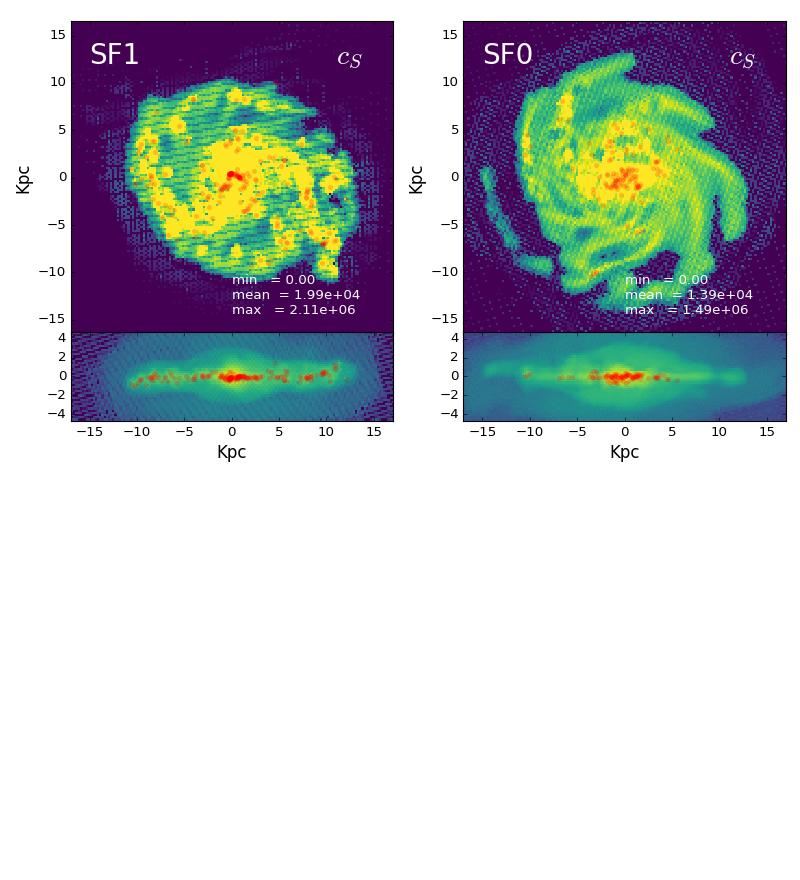

2111095.4375
10703089.660095215
1485890.609375
5127625.9894104


In [15]:
#fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,5])
fig, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,gridspec_kw = {'height_ratios':[3.5, 1.,3.5,1.]},figsize=[10,11],sharex=True)
length,thik=17,0.3
ax.set_ylim([-length,length]);ax.set_xlim([-length,length])
ax2.set_ylim([-length,length]);ax2.set_xlim([-length,length])
ax3.set_ylim([-4,4])

elmax = SF1140_faceOn.max()
SF1140_faceOn,edges= face_on_gs_cs2(myhalo,[-length,length],150,thikness=thik)#H.T 
print SF1140_faceOn.max()
mass_2 = ax.imshow(SF1140_faceOn+1e-1, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=elmax)
                  )
"""
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax.text(-15,12,"SF1",fontsize=25,color='w')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax.text(0,-16,texto,color='w')
ax.text(11,12,r"$c_S$",fontsize=25,color='w')



SF1140_faceOn,edges= edge_on_gs_cs2(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax2.imshow(SF1140_faceOn+1e-1, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=SF1140_faceOn.max())
                  )


ax.set_ylabel("Kpc",fontsize=15)
ax2.set_xlabel("Kpc",fontsize=15)


SF1140_faceOn,edges= face_on_gs_cs2(SF0,[-length,length],150,thikness=thik)#H.T 
print SF1140_faceOn.max()
mass_2 = ax1.imshow(SF1140_faceOn+1e-2, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=elmax)
                  )
"""
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax1.text(-15,12,"SF0",fontsize=25,color='w')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax1.text(0,-16,texto,color='w')
ax1.text(11,12,r"$c_S$",fontsize=25,color='w')
ax1.set_ylabel("Kpc",fontsize=15)
ax3.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= edge_on_gs_cs2(SF0,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax3.imshow(SF1140_faceOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=SF1140_faceOn.max())
                  )

ax.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,1],
           lw=0,c='r',alpha=0.2)
                       

ax1.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,1],
            lw=0,c='r',alpha=0.2)
ax2.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,2],lw=0,c='r',alpha=0.2)
ax3.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,2],
            lw=0,c='r',alpha=0.2)

fig.tight_layout(h_pad=-1)

<IPython.core.display.Javascript object>


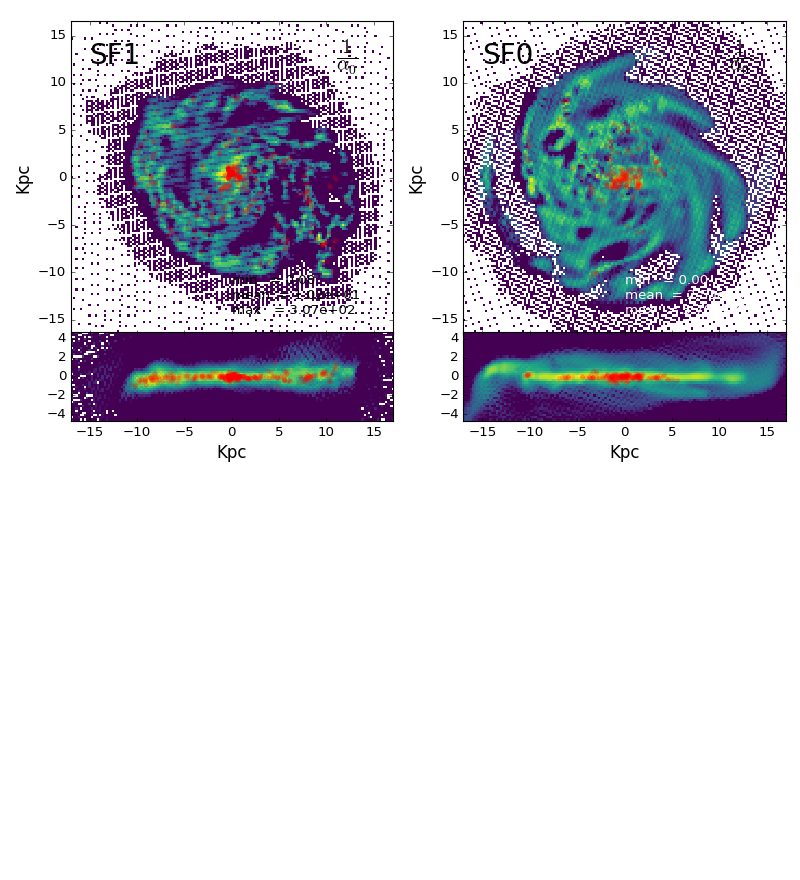

307.40626795589924
2117.300682931673
569.607780456543
4052.4708344356623


In [43]:
#fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,5])
fig, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,gridspec_kw = {'height_ratios':[3.5, 1,3.5,1]},figsize=[10,11],sharex=True)
length=17
ax3.set_ylim([-4,4])

ax.set_ylim([-length,length]);ax.set_xlim([-length,length])
ax2.set_ylim([-length,length]);ax2.set_xlim([-length,length])

SF1140_faceOn,edges= face_on_gs_alpha0(myhalo,[-length,length],150,thikness=0.3)#H.T 
print SF1140_faceOn.max()
mass_2 = ax.imshow(SF1140_faceOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=0.9*SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax.text(-15,12,"SF1",fontsize=25,color='k')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax.text(0,-16,texto,color='k')
ax.text(11,12,r"$\frac{1}{\alpha_0}$",fontsize=25,color='k')


SF1140_faceOn,edges= edge_on_gs_alpha0(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax2.imshow(SF1140_faceOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=0.9*SF1140_faceOn.max())
                  )

ax.set_ylabel("Kpc",fontsize=15)
ax2.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= face_on_gs_alpha0(SF0,[-length,length],150,thikness=0.3)#H.T 
print SF1140_faceOn.max()
mass_2 = ax1.imshow(SF1140_faceOn, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=0.9*SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax1.text(-15,12,"SF0",fontsize=25,color='k')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax1.text(0,-16,texto,color='w')
ax1.text(11,12,r"$\frac{1}{\alpha_0}$",fontsize=25,color='k')
ax1.set_ylabel("Kpc",fontsize=15)
ax3.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= edge_on_gs_alpha0(SF0,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax3.imshow(SF1140_faceOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=10,vmax=0.9*SF1140_faceOn.max())
                  )
youngestSF1 = np.where(myhalo.st.age>-0.01)
ax.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,1],lw=0,c='r',alpha=0.2)
ax1.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,1],
            lw=0,c='r',alpha=0.2)
youngestSF0 = np.where(SF0.st.age>-0.01)
ax2.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,2],lw=0,c='r',alpha=0.2)
ax3.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,2],
            lw=0,c='r',alpha=0.2)
fig.tight_layout(h_pad=-1)

In [16]:
np.sqrt(SF0.st.sf_info.sigma2)

AttributeError: _stars instance has no attribute 'sf_info'

In [17]:
print myhalo.st.sf_info.rho.max()

1861457511.324999


In [18]:
fig, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2)
######################### Mach ######################################
ax.set_xlabel('$\mathcal{M}$',fontsize=20)
bins = np.linspace(0,3,100)
M2_histSF0, M2_binsSF0 = np.histogram( np.sqrt(SF0.st.sf_info.M2)
                                      ,bins=bins,normed=True )
wsf0  = M2_binsSF0[1:] - M2_binsSF0[:-1]
csf0  = (M2_binsSF0[1:] + M2_binsSF0[:-1])/2.  

M2_histSF1, M2_binsSF1 = np.histogram( np.sqrt(myhalo.st.sf_info.M2)
                                      ,bins=bins,normed=True )
wsf1  = M2_binsSF1[1:] - M2_binsSF1[:-1]
csf1  = (M2_binsSF1[1:] + M2_binsSF1[:-1])/2.  


ax.bar(csf0,M2_histSF0,width=wsf0,color='b',alpha=0.8,lw=0)
ax.bar(csf1,M2_histSF1,width=wsf1,color='r',alpha=0.6,lw=0)

#################### Sound Speed ###################################
ax1.set_xlabel(r"$\sigma$",fontsize=20)
bins = np.linspace(0,700,100)
cs_histSF0, cs_binsSF0 = np.histogram( np.sqrt(SF0.st.sf_info.sigma2)
                                      ,bins=bins,normed=True )
wsf0  = cs_binsSF0[1:] - cs_binsSF0[:-1]
csf0  = (cs_binsSF0[1:] + cs_binsSF0[:-1])/2.  

cs_histSF1, cs_binsSF1 = np.histogram( np.sqrt(myhalo.st.sf_info.sigma2)
                                      ,bins=bins,normed=True)
wsf1  = cs_binsSF1[1:] - cs_binsSF1[:-1]
csf1  = (cs_binsSF1[1:] + cs_binsSF1[:-1])/2.  

ax1.set_xlim([0,500])
ax1.bar(csf0,cs_histSF0,width=wsf0,color='b',alpha=0.8,lw=0)
ax1.bar(csf1,cs_histSF1,width=wsf1,color='r',alpha=0.6,lw=0)

#################### alpha0 ###################################
ax2.set_xlabel(r"$\alpha_0$",fontsize=20)

al_histSF0, al_binsSF0 = np.histogram( SF0.st.sf_info.alpha0,
                                      bins=bins,normed=True )

bins = np.linspace(0,0.05,100)
al_histSF0, al_binsSF0 = np.histogram( SF0.st.sf_info.alpha0,
                                      bins=bins,normed=True )
wsf0  = al_binsSF0[1:] - al_binsSF0[:-1]
csf0  = (al_binsSF0[1:] + al_binsSF0[:-1])/2.  

al_histSF1, al_binsSF1 = np.histogram( myhalo.st.sf_info.alpha0
                                      ,bins=bins,normed=True)
wsf1  = al_binsSF1[1:] - al_binsSF1[:-1]
csf1  = (al_binsSF1[1:] + al_binsSF1[:-1])/2.  

ax2.set_xlim([0,0.03])
ax2.bar(csf0,al_histSF0,width=wsf0,color='b',alpha=0.8,lw=0)
ax2.bar(csf1,al_histSF1,width=wsf1,color='r',alpha=0.6,lw=0)

################### rho ########################################

ax3.set_xlabel(r"$\rho$",fontsize=20)


bins = np.logspace(0,10,100)
rho_histSF0, rho_binsSF0 = np.histogram( SF0.st.sf_info.rho,
                                      bins=bins,normed=True )
wsf0  = rho_binsSF0[1:] - rho_binsSF0[:-1]
csf0  = (rho_binsSF0[1:] + rho_binsSF0[:-1])/2.  

rho_histSF1, rho_binsSF1 = np.histogram( myhalo.st.sf_info.rho
                                      ,bins=bins,normed=True)
wsf1  = rho_binsSF1[1:] - rho_binsSF1[:-1]
csf1  = (rho_binsSF1[1:] + rho_binsSF1[:-1])/2.  
ax3.set_xscale('log')
ax3.set_xlim([1e6,1e11])
ax3.bar(csf0,rho_histSF0,width=wsf0,color='b',alpha=0.8,lw=0)
ax3.bar(csf1,rho_histSF1,width=wsf1,color='r',alpha=0.6,lw=0)
ax3.axvline(x=SF0.p.rhoc_SF,color='k',linestyle='--')
fig.tight_layout()

<IPython.core.display.Javascript object>

AttributeError: _stars instance has no attribute 'sf_info'

In [31]:
SF0.p.rhoc_SF

9.363990227420888e+37

<IPython.core.display.Javascript object>


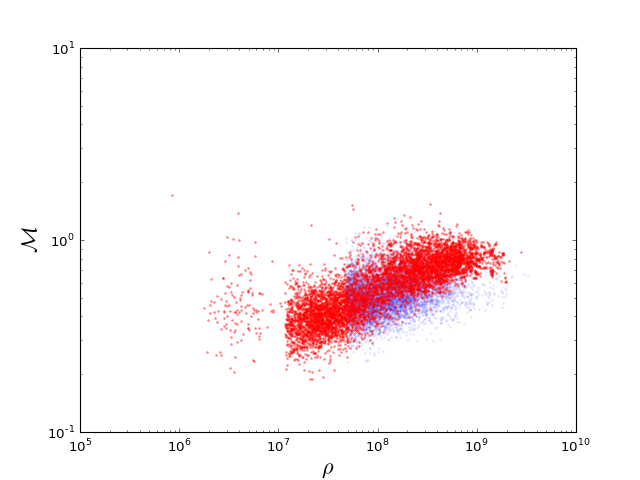

In [72]:
fig, ax =plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rho$',fontsize=20)
ax.set_ylabel(r'$\mathcal{M}$',fontsize=20)
#ax.axvline(x=rhoc_SF0,color='k',linestyle='--')
ax.scatter(SF0.st.sf_info.rho ,np.sqrt(SF0.st.sf_info.M2),lw=0,alpha=0.1,s=5,c='b')
ax.scatter(myhalo.st.sf_info.rho,np.sqrt(myhalo.st.sf_info.M2),lw=0,alpha=0.5,s=5,c='r')
#ax.scatter(myhalo.st.sf_info.rho_crit,np.sqrt(myhalo.st.sf_info.M2),lw=0,alpha=0.5,s=1,c='g')


<IPython.core.display.Javascript object>


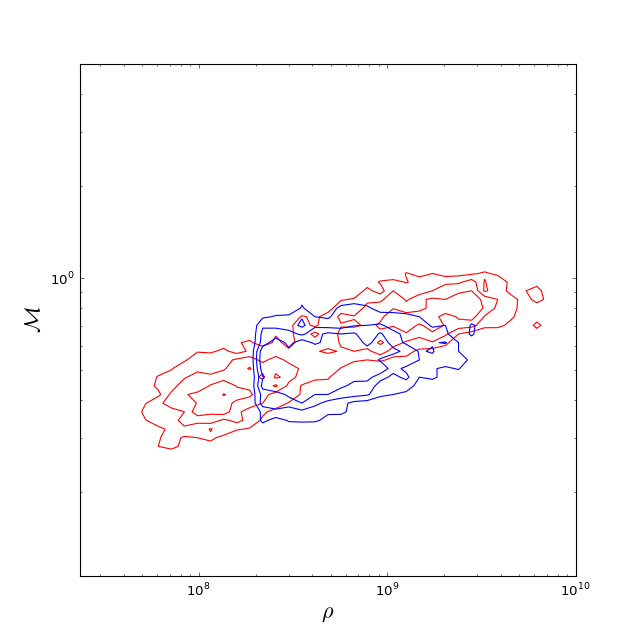

(0.10671000203930622, 5)

In [21]:
points=40
xedges = np.logspace(7.3,10,points)
yedges = np.logspace(-1,0.1,points)

H, xedges, yedges = np.histogram2d(myhalo.st.sf_info.rho, 
                                   np.sqrt(myhalo.st.sf_info.M2),
                                   bins=(xedges, yedges))
Z1 = H.T

H, xedges, yedges = np.histogram2d(SF0.st.sf_info.rho, 
                                   np.sqrt(SF0.st.sf_info.M2),
                                   bins=(xedges, yedges))
Z0 = H.T

fig, ax = plt.subplots(figsize=[8,8])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$',fontsize=20)
ax.set_ylabel(r'$\mathcal{M}$',fontsize=20)

X, Y = np.meshgrid(xedges[1:], yedges[1:])
ma = Z1.max()
CS1 = ax.contour(X, Y, Z1,[0.2*ma,0.4*ma,0.6*ma],colors='r')
ma = Z0.max()
CS2 = ax.contour(X, Y, Z0,[0.2*ma,0.4*ma,0.6*ma],colors='b')
ax.set_ylim([-5,5])



5791
5791


<IPython.core.display.Javascript object>


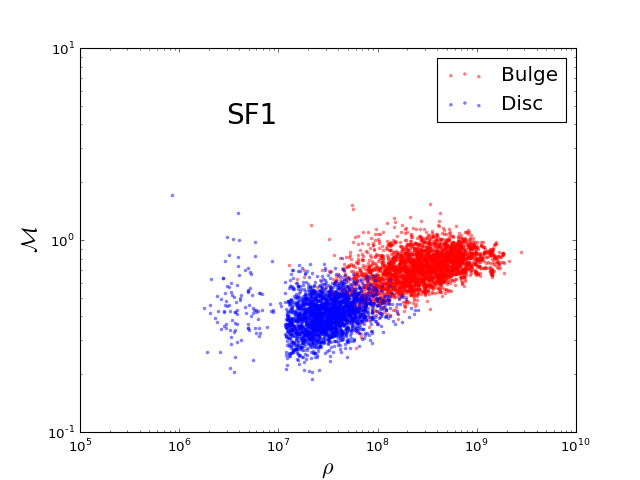

In [73]:
age_cut = -0.3
newStarsSF1 = np.in1d(myhalo.st.id,myhalo.st.sf_info.id)
SYnewStarsSF1 = (myhalo.st.age>age_cut)*newStarsSF1
SYbackwardsSF1 = np.in1d(myhalo.st.sf_info.id,myhalo.st.id[(myhalo.st.age>age_cut)])
print len(myhalo.st.age[SYnewStarsSF1])
print len(myhalo.st.sf_info.rho[SYbackwardsSF1])
# to make sure both correspond to eachother element to element
id_sim_SF1 = np.argsort(myhalo.st.id[SYnewStarsSF1])
id_sf_SF1 = np.argsort(myhalo.st.sf_info.id[SYbackwardsSF1])
# from srf_info
rho_SF1 = myhalo.st.sf_info.rho[SYbackwardsSF1]
rho_SF1 = rho_SF1[id_sf_SF1]
M2_SF1 = myhalo.st.sf_info.M2[SYbackwardsSF1]
M2_SF1 = M2_SF1[id_sf_SF1]
# from stars in simu
r_SF1 = myhalo.st.r[SYnewStarsSF1]
r_SF1 = r_SF1[id_sim_SF1]


fig, ax =plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rho$',fontsize=20)
ax.set_ylabel(r'$\mathcal{M}$',fontsize=20)

limit = 4

ax.scatter(rho_SF1[(r_SF1<3.)],np.sqrt(M2_SF1[(r_SF1<3.)]),lw=0,alpha=0.5,s=10,c='r',label='Bulge')
ax.scatter(rho_SF1[(r_SF1>3.)],np.sqrt(M2_SF1[(r_SF1>3.)]),lw=0,alpha=0.5,s=10,c='b',label='Disc')
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=18)
ax.text(3e6,4,'SF1',fontsize=25)
#ax.scatter(SF0.st.sf_info.rho[smaR],np.sqrt(myhalo.st.sf_info.M2[smaR]),lw=0,alpha=0.5,s=1,c='k')

#ax.scatter(myhalo.st.sf_info.rho_crit,np.sqrt(myhalo.st.sf_info.M2),lw=0,alpha=0.5,s=1,c='g')


5098
5098


<IPython.core.display.Javascript object>


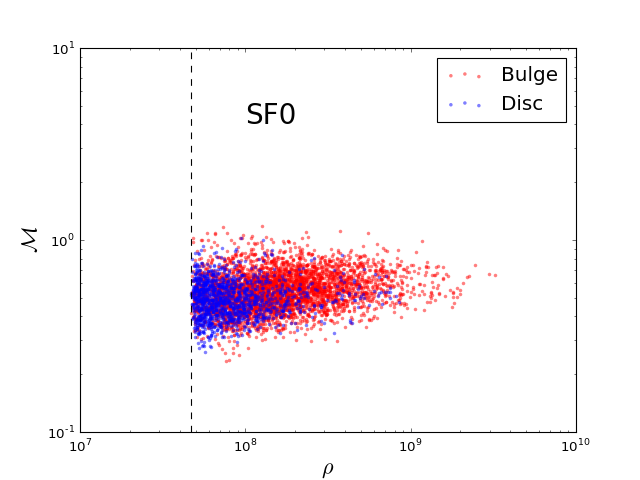

In [75]:
newStarsSF0 = np.in1d(SF0.st.id,SF0.st.sf_info.id)
SYnewStarsSF0 = (SF0.st.age>age_cut)*newStarsSF0
SYbackwardsSF0 = np.in1d(SF0.st.sf_info.id,SF0.st.id[(SF0.st.age>age_cut)])
print len(SF0.st.age[SYnewStarsSF0])
print len(SF0.st.sf_info.rho[SYbackwardsSF0])
# to make sure both correspond to eachother element to element
id_sim_SF0 = np.argsort(SF0.st.id[SYnewStarsSF0])
id_sf_SF0 = np.argsort(SF0.st.sf_info.id[SYbackwardsSF0])
# from srf_info
rho_SF0 = SF0.st.sf_info.rho[SYbackwardsSF0]
rho_SF0 = rho_SF0[id_sf_SF0]
M2_SF0 = SF0.st.sf_info.M2[SYbackwardsSF0]
M2_SF0 = M2_SF0[id_sf_SF0]
# from stars in simu
r_SF0 = SF0.st.r[SYnewStarsSF0]
r_SF0 = r_SF0[id_sim_SF0]


fig, ax =plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rho$',fontsize=20)
ax.set_ylabel(r'$\mathcal{M}$',fontsize=20)

limit = 4

ax.scatter(rho_SF0[(r_SF0<3.)],np.sqrt(M2_SF0[(r_SF0<3.)]),lw=0,alpha=0.5,s=10,c='r',label="Bulge")
ax.scatter(rho_SF0[(r_SF0>3.)],np.sqrt(M2_SF0[(r_SF0>3.)]),lw=0,alpha=0.5,s=10,c='b',label="Disc")
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=18)
ax.text(1.e8,4,'SF0',fontsize=25)
#ax.scatter(myhalo.st.sf_info.rho[smaR],np.sqrt(myhalo.st.sf_info.M2[smaR]),lw=0,alpha=0.5,s=1,c='k')

#ax.scatter(myhalo.st.sf_info.rho_crit,np.sqrt(myhalo.st.sf_info.M2),lw=0,alpha=0.5,s=1,c='g')
m_H = 1.67e-27/SF0.p.msuntokg # msun

ax.axvline(x=rhoc_SF0,color='k',linestyle='--')


<IPython.core.display.Javascript object>


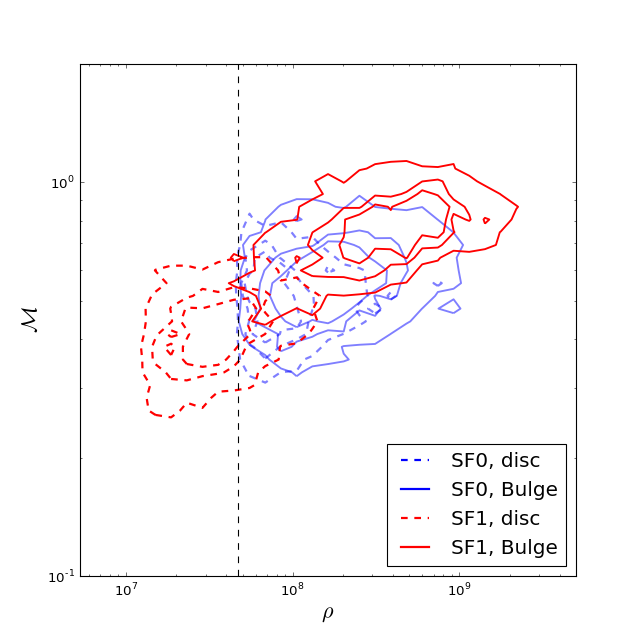

In [97]:
### 
points=35
xedges = np.logspace(6.8,10,points)
yedges = np.logspace(-1,0.1,points)



H, xedges, yedges = np.histogram2d(rho_SF1[(r_SF1<3.)], 
                                   np.sqrt(M2_SF1[(r_SF1<3.)]),
                                   bins=(xedges, yedges))
Z1_B = H.T

H, xedges, yedges = np.histogram2d(rho_SF1[(r_SF1>3.)], 
                                   np.sqrt(M2_SF1[(r_SF1>3.)]),
                                   bins=(xedges, yedges))
Z1_D = H.T

H, xedges, yedges = np.histogram2d(rho_SF0[(r_SF0<3.)], 
                                   np.sqrt(M2_SF0[(r_SF0<3.)]),
                                   bins=(xedges, yedges))
Z0_B = H.T

H, xedges, yedges = np.histogram2d(rho_SF0[(r_SF0>3.)], 
                                   np.sqrt(M2_SF0[(r_SF0>3.)]),
                                   bins=(xedges, yedges))
Z0_D = H.T

fig, ax = plt.subplots(figsize=[8,8])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$',fontsize=20)
ax.set_ylabel(r'$\mathcal{M}$',fontsize=20)
ax.set_ylim([0.1,2])
ax.set_xlim([5.3e6,5e9])
ax.axvline(x=rhoc_SF0,color='k',linestyle='--')

X, Y = np.meshgrid(xedges[1:], yedges[1:])
ma = Z0_B.max()
CS1 = ax.contour(X, Y, Z0_B,[0.1*ma,0.4*ma,0.6*ma],linestyles='solid',linewidths=1.7,colors='b',alpha=0.5,label="Bulge, SF0")
ma = Z0_D.max()
CS2 = ax.contour(X, Y, Z0_D,[0.1*ma,0.4*ma,0.6*ma],linestyles='dashed',linewidths=2,colors='b',alpha=0.5,label="Disc, SF0")

ma = Z1_B.max()
CS1 = ax.contour(X, Y, Z1_B,[0.1*ma,0.4*ma,0.6*ma],linestyles='solid',linewidths=1.7,colors='r',label="Bulge, SF1")
ma = Z1_D.max()
CS2 = ax.contour(X, Y, Z1_D,[0.1*ma,0.4*ma,0.6*ma],linestyles='dashed',linewidths=2,colors='r',label="Disc, SF1")

ax.plot([1,2,3],[1,2,3],'b--',lw=2,label="SF0, disc")
ax.plot([1,2,3],[1,2,3],'b-',lw=2,label="SF0, Bulge")
ax.plot([1,2,3],[1,2,3],'r--',lw=2,label="SF1, disc")
ax.plot([1,2,3],[1,2,3],'r-',lw=2,label="SF1, Bulge")



legend = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=18)
frame = legend.get_frame()


In [230]:
R_array = np.linspace(0,12,35)
E_gs_SF0 = E_gs_SF1 = E_sf_SF0 = E_sf_SF1 = np.array([])

for i in range(len(R_array)-1):
    D_gs = (SF0.gs.R>R_array[i])&(SF0.gs.R<=R_array[i+1])&(np.abs(SF0.gs.pos3d[:,2])<1)
    D_st = (SF0.st.R>R_array[i])&(SF0.st.R<=R_array[i+1])&(np.abs(SF0.st.pos3d[:,2])<1)&(SF0.st.age>-0.05)
    E_gs_SF0 = np.append(E_gs_SF0,np.sum(SF0.gs.mass[D_gs]))
    E_sf_SF0 = np.append(E_sf_SF0,np.sum(SF0.st.mass[D_st]/(-SF0.st.age[D_st]*1e9)))
    D_gs = (myhalo.gs.R>R_array[i])&(myhalo.gs.R<=R_array[i+1])&(np.abs(myhalo.gs.pos3d[:,2])<1)
    D_st = (myhalo.st.R>R_array[i])&(myhalo.st.R<=R_array[i+1])&(np.abs(myhalo.st.pos3d[:,2])<1)&(myhalo.st.age>-0.05)
    E_gs_SF1 = np.append(E_gs_SF1,np.sum(myhalo.gs.mass[D_gs]))
    E_sf_SF1 = np.append(E_sf_SF1,np.sum(myhalo.st.mass[D_st]/(-myhalo.st.age[D_st]*1e9)))
    
Areas = np.pi*(R_array[1:]**2 - R_array[:-1]**2)
E_gs_SF0 /= Areas*1e6#pc^2
E_gs_SF1 /= Areas*1e6#pc^2
E_sf_SF0 /= Areas
E_sf_SF1 /= Areas


    

In [231]:
print E_sf_SF1


[ 2.35539317e+01  2.59227769e+00  1.19499024e+00  1.01685398e+00
 -5.49653201e-01  1.67173932e-01  1.01296476e-01  2.71503337e-02
  5.31523208e-02 -5.92632444e-02 -1.74676986e-01  2.68122334e-02
  3.01917718e-02  3.83491151e-04  2.92677373e-03  1.49663395e-02
  1.97377251e-03  2.16036199e-02  9.59031993e-02 -1.16650243e-03
 -2.20736255e-02  3.44051620e-02  5.94296104e-03 -8.64785757e-02
 -1.73528102e-02  7.54956751e-03  1.07600402e-01  1.12411978e-02
  9.50249686e-04  5.91572231e-03  8.08194825e-03  3.63036787e-03
 -2.28983299e-02  2.43125746e-03]


In [232]:
SF0.st.age.min()

-13.508982

<IPython.core.display.Javascript object>


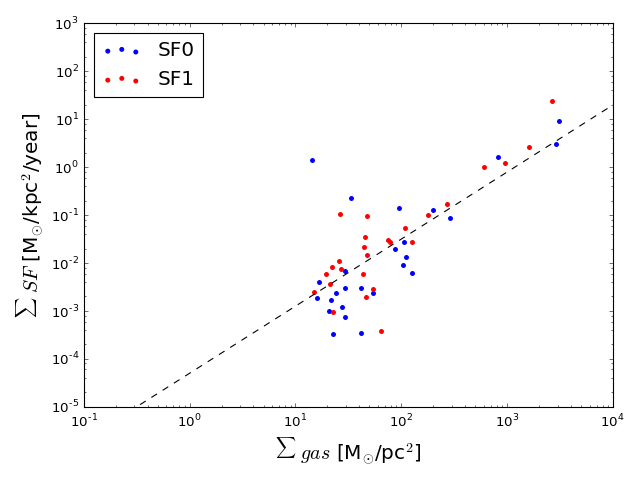

In [250]:
fig, ax = plt.subplots()
ax.set_xlim([0.1,1e4])
ax.set_ylim([1e-5,1e3])
ax.set_xlabel(r"$ ^{\sum}\,gas$ [M$_{\odot}$/pc$^2$]",fontsize=18)
ax.set_ylabel(r"$ ^{\sum}\,SF$ [M$_{\odot}$/kpc$^2$/year]",fontsize=18)

ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(E_gs_SF0,E_sf_SF0,color='b',lw=0,label="SF0")
ax.scatter(E_gs_SF1,E_sf_SF1,color='r',lw=0,label="SF1")

ax.plot(np.logspace(-1,5,40),0.00005*(np.logspace(-1,5,40))**(1.4),'k--')
fig.tight_layout()
legend = ax.legend(loc='upper left', ncol=1, shadow=False, fontsize=18)


<IPython.core.display.Javascript object>


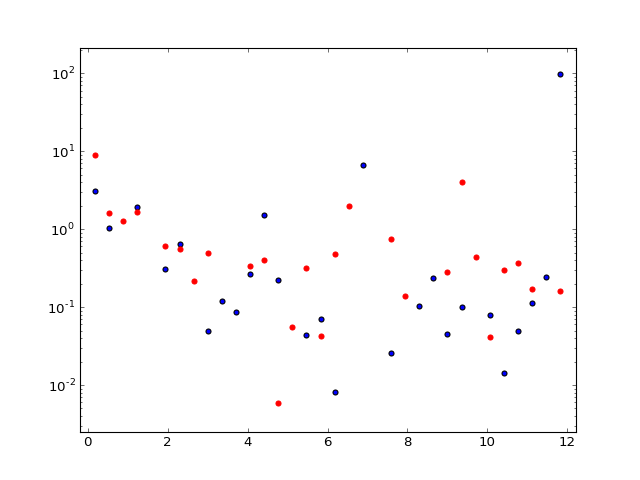

In [254]:
fig, ax = plt.subplots()
ax.set_yscale('log')
R = (R_array[1:]+R_array[:-1])/2.
ax.scatter(R,E_sf_SF0*1e3 / E_gs_SF0)
ax.scatter(R,E_sf_SF1*1e3 / E_gs_SF1,color='r')

In [ ]:
cut ,thikness,length= 4.3e8,5.5,17
dens_cut = np.where((myhalo.gs.rho>4.3e8))[0]
disc = dens_cut#np.where(np.abs(myhalo.gs.pos3d[dens_cut,2])<thikness)[1]
print myhalo.gs.r[disc].min()
edges = np.linspace(-length,length,150)
H, xedges, yedges = np.histogram2d(myhalo.gs.pos3d[disc,0], 
                                   myhalo.gs.pos3d[disc,1],
                                   bins=(edges, edges))
gasmap = H.T

fig, ax = plt.subplots()
mass_2 = ax.imshow(gasmap, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]]
                  )

In [ ]:
print gasmap.max()


In [ ]:
bins = np.logspace(3,11,100)
thinkness = 0.5
discSF1=np.where((myhalo.gs.r<17)&(np.abs(myhalo.gs.pos3d[:,2])<thinkness))
discSF0=np.where((SF0.gs.r<17)&(np.abs(SF0.gs.pos3d[:,2])<thinkness))
full_histSF1, full_binsSF1 = np.histogram(myhalo.gs.rho[discSF1],bins=bins,normed=0)
cf_SF1 = full_binsSF1[:-1]+ ((full_binsSF1[1:]-full_binsSF1[:-1])/2.)
wf_SF1 = (full_binsSF1[1:]-full_binsSF1[:-1])

full_histSF0, full_binsSF0 = np.histogram(SF0.gs.rho[discSF0],bins=bins,normed=0)
cf_SF0 = full_binsSF0[:-1]+ ((full_binsSF0[1:]-full_binsSF0[:-1])/2.)
wf_SF0 = (full_binsSF0[1:]-full_binsSF0[:-1])

rho_histSF0, rho_binsSF0 = np.histogram( SF0.st.sf_info.rho,
                                      bins=bins,normed=0 )
wsf0  = rho_binsSF0[1:] - rho_binsSF0[:-1]
csf0  = rho_binsSF0[:-1]+(rho_binsSF0[1:] -rho_binsSF0[:-1])/2.  

rho_histSF1, rho_binsSF1 = np.histogram( myhalo.st.sf_info.rho
                                      ,bins=bins,normed=0)
wsf1  = rho_binsSF1[1:] - rho_binsSF1[:-1]
csf1  = rho_binsSF1[:-1]+(rho_binsSF1[1:] - rho_binsSF1[:-1])/2. 
print np.sum(rho_histSF1*wsf1)
print np.sum(full_histSF0*wf_SF0)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.step(cf_SF0,full_histSF0,color='b',lw=1.5)
ax.step(csf0,rho_histSF0,linestyle='--',color='b',lw=1.5)

ax.step(cf_SF1,full_histSF1,color= 'r',lw=1.5)
ax.step(csf1,rho_histSF1,linestyle='--',color='r',lw=1.5)
ax.axvline(x=rhoc_SF0,color='k',linestyle='--',lw=2)


In [ ]:
disc = (SF0.st.r<7)&(np.abs(SF0.st.pos3d[:,2])<3)

In [ ]:
SF0.st.pos3d *= [1,-1,-1]

In [ ]:
i=(SF0.st.pos3d[disc,1]*SF0.st.vel3d[disc,2]/SF0.p.kpctokm)-(SF0.st.pos3d[disc,2]*SF0.st.vel3d[disc,1]/SF0.p.kpctokm)
j=(SF0.st.pos3d[disc,2]*SF0.st.vel3d[disc,0]/SF0.p.kpctokm)-(SF0.st.pos3d[disc,0]*SF0.st.vel3d[disc,2]/SF0.p.kpctokm)
k=(SF0.st.pos3d[disc,0]*SF0.st.vel3d[disc,1]/SF0.p.kpctokm)-(SF0.st.pos3d[disc,1]*SF0.st.vel3d[disc,0]/SF0.p.kpctokm)

In [ ]:
SF0.st.vR[disc].mean()

In [ ]:
SF0.st.vR[disc]

In [ ]:
SF0.redefine(2)

In [ ]:
ok,myhalo.dm.rho,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)
ok,SF0.dm.rho,_= CF.getDensity(np.array(SF0.dm.pos3d.reshape(len(SF0.dm.pos3d)*3),dtype=np.float32), SF0.dm.mass)

# Density profile

In [6]:


hsml = myhalo.gs.hsml.min()
# R array logarithmic Bining
binnum = 2**7
r_p = np.logspace(np.log10(hsml),np.log10(2.5*myhalo.r200),binnum)

Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]

n_dm,r = np.histogram(myhalo.dm.r,bins=r_p)
n_st,r = np.histogram(myhalo.st.r,bins=r_p)
m_st,r = np.histogram(myhalo.st.r,bins=r_p,weights=myhalo.st.mass)

vol = np.array([])
r1,r2 =r_p[:-1],r_p[1:]
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
profileDM = n_dm*myhalo.dm.mass[0]/vol
profileST = m_st/vol
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean_dm = mean_st = n_st = n_dm = std_dm = std_st = np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1])&(myhalo.dm.r > hsml))
    n_dm = np.append(n_dm,len(shell[0]))
    mean_dm = np.append(mean_dm,np.mean(myhalo.dm.rho[shell]))
    std_dm = np.append(std_dm,np.std(myhalo.dm.rho[shell]))

    shell_st = np.where((myhalo.st.r > r_p[i])&(myhalo.st.r < r_p[i+1])&(myhalo.st.r > hsml))
    n_st = np.append(n_st,len(shell_st[0]))
    mean_st = np.append(mean_st,np.mean(myhalo.st.rho[shell_st]))
    std_st = np.append(std_st,np.std(myhalo.st.rho[shell_st]))

pdm_sf1, pst_sf1 = profileDM, profileST
sdm_sf1, sst_sf1 = std_dm, std_st

##################################################################
############ SF0 ################
hsml = SF0.gs.hsml.min()
# R array logarithmic Bining
n_dm,r = np.histogram(SF0.dm.r,bins=r_p)
n_st,r = np.histogram(SF0.st.r,bins=r_p)
m_st,r = np.histogram(SF0.st.r,bins=r_p,weights=SF0.st.mass)

vol = np.array([])
r1,r2 =r_p[:-1],r_p[1:]
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
profileDM = n_dm*SF0.dm.mass[0]/vol
profileST = m_st/vol
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean_dm = mean_st = n_st = n_dm = std_dm = std_st = np.array([])
for i in range(len(r_p)-1):
    shell = np.where((SF0.dm.r > r_p[i])&(SF0.dm.r < r_p[i+1])&(SF0.dm.r > hsml))
    n_dm = np.append(n_dm,len(shell[0]))
    mean_dm = np.append(mean_dm,np.mean(SF0.dm.rho[shell]))
    std_dm = np.append(std_dm,np.std(SF0.dm.rho[shell]))

    shell_st = np.where((SF0.st.r > r_p[i])&(SF0.st.r < r_p[i+1])&(SF0.st.r > hsml))
    n_st = np.append(n_st,len(shell_st[0]))
    mean_st = np.append(mean_st,np.mean(SF0.st.rho[shell_st]))
    std_st = np.append(std_st,np.std(SF0.st.rho[shell_st]))

pdm_sf0, pst_sf0 = profileDM, profileST
sdm_sf0, sst_sf0 = std_dm, std_st



In [7]:
deltasf1 = np.abs((pst_sf1/pdm_sf1)-1)
print deltasf1.min()
r[np.where(deltasf1==deltasf1.min())[0]]

0.018433643564005342


array([3.082331])

<IPython.core.display.Javascript object>


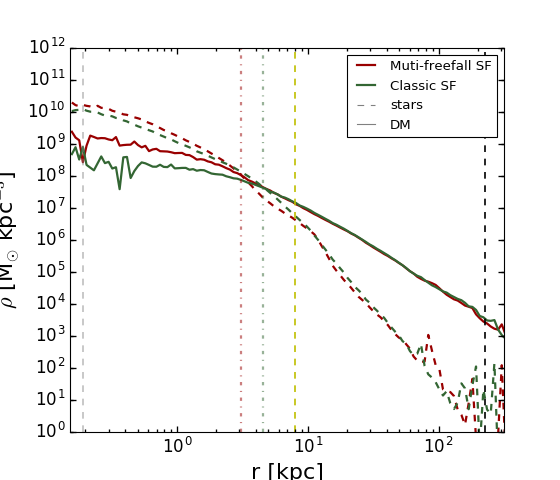

0.19039162


In [8]:
fig, ax= plt.subplots(figsize=[7,6])
######### SF1
ax.set_xlim([0.8*hsml,10**2.5])
ax.set_ylim([1,1e12])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e0,1e12])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax.set_title("",fontsize=15)

#### DM ####
ax.plot(r,pdm_sf1,color='#990000', ls="-",lw=2,label='Muti-freefall SF')
### Stars ###
ax.plot(r,pst_sf1,color='#990000',ls='--',lw=2 )
#### DM ####
ax.plot(r,pdm_sf0,color="#336633" ,ls="-",lw=2,label='Classic SF' )
### Stars ###
ax.plot(r,pst_sf0,color="#336633" ,ls='--',lw=2 )
####

deltasf1 = np.abs((pst_sf1/pdm_sf1)-1)
cross_sf1 = r[np.where(deltasf1==deltasf1.min())]
deltasf0 = np.abs((pst_sf0/pdm_sf0)-1)
cross_sf0 = r[np.where(deltasf0==deltasf0.min())]
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=cross_sf1,c='#990000',alpha=0.5,linestyle='-.',lw=2)
ax.axvline(x=cross_sf0,c='#336633',alpha=0.5,linestyle='-.',lw=2)
ax.plot([1e14,2e14],[1e14,2e14],color='gray',ls='--',label="stars")
ax.plot([1e14,2e14],[1e14,2e14],color='gray',ls='-',label="DM")
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhalo.r200,c='k',linestyle='--',lw=1.5) #r200
print hsml
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)


<IPython.core.display.Javascript object>


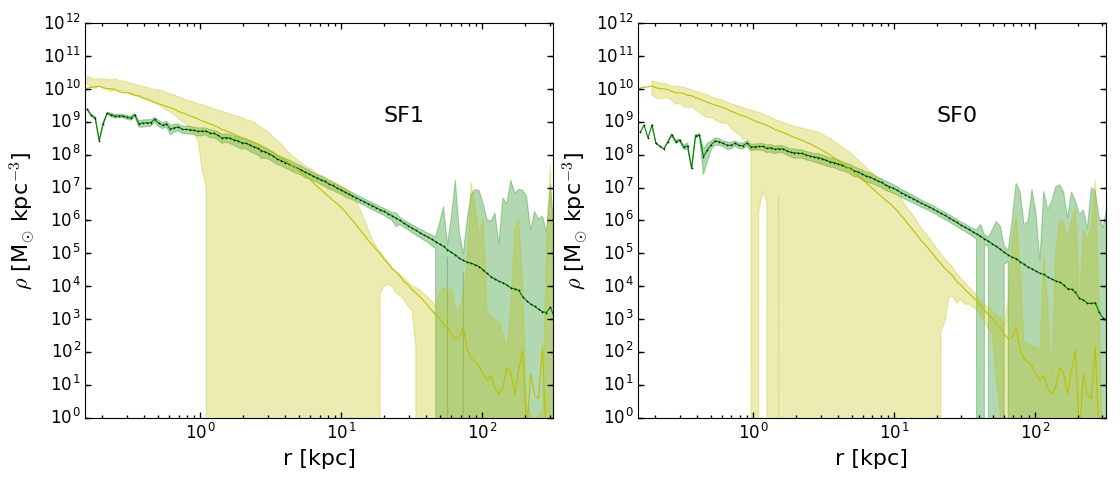

In [10]:
fig, [ax,ax1]= plt.subplots(1,2,figsize=[14,6])
######### SF1
ax.set_xlim([r_p[0],10**2.5])
ax.set_ylim([1,1e12])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e0,1e12])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax.set_title("",fontsize=15)
#### DM ####
ax.plot(r,pdm_sf1,"g-o",markersize=1)
ax.fill_between(r,pdm_sf1+sdm_sf1,pdm_sf1-sdm_sf1,color="g",alpha=0.3)
### Stars ###
ax.text(20,1e9,"SF1",fontsize=20)
ax.plot(r,profileST,'y' )
ax.fill_between(r,pst_sf1 +sst_sf1,pst_sf1-sst_sf1,color="y",alpha=0.3)
####
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

######### SF0
ax1.set_xlim([r_p[0],10**2.5])
ax1.set_ylim([1,1e12])
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylim([1e0,1e12])
ax1.set_xlabel(r"r [kpc]",fontsize=20)
ax1.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax1.set_title("",fontsize=15)
#### DM ####
ax1.text(20,1e9,"SF0",fontsize=20)
ax1.plot(r,pdm_sf0,"g-o",markersize=1)
ax1.fill_between(r,pdm_sf0+sdm_sf0,pdm_sf0-sdm_sf0,color="g",alpha=0.3)
### Stars ###
ax1.plot(r,pst_sf0,'y' )
ax1.fill_between(r,pst_sf0+sst_sf0,pst_sf0-sst_sf0,color="y",alpha=0.3)
####
legend = ax1.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)
fig.tight_layout(h_pad=-1.65)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

# star formation

<IPython.core.display.Javascript object>


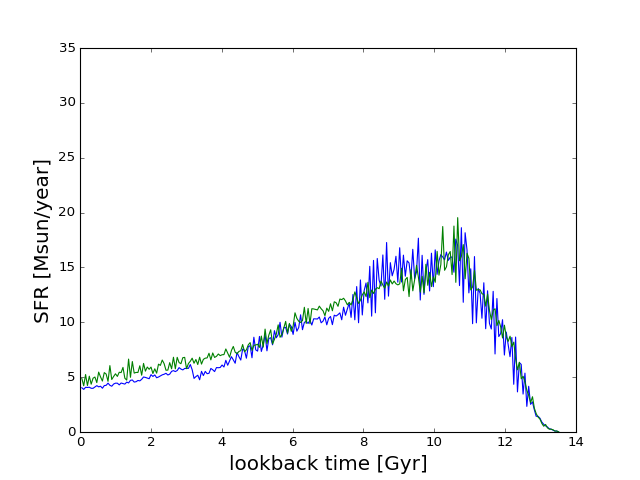

In [21]:
binnum = 2**8

age_histsf1 = np.histogram(myhalo.st.age,bins=binnum,weights=myhalo.st.mass)
age_histsf0 = np.histogram(SF0.st.age,bins=binnum,weights=SF0.st.mass)
fig,ax = plt.subplots()
ax.set_ylim([0,35])
ax.set_ylabel("SFR [Msun/year]", fontsize=18)
ax.set_xlabel("lookback time [Gyr]", fontsize=18)
thiknesssf0=age_histsf0[1][1]-age_histsf0[1][0]
thiknesssf1=age_histsf1[1][1]-age_histsf1[1][0]

ax.plot(-1*age_histsf0[1][:-1],age_histsf0[0]/(thiknesssf0*1e9)/SF0.p.aexp)
ax.plot(-1*age_histsf1[1][:-1],age_histsf1[0]/(thiknesssf1*1e9)/myhalo.p.aexp)


In [34]:
SF0.gs.temp2.max()

5272836.5

# with sf_info now 

In [21]:
SF0.st.gotsfInfo

True

In [22]:
a = 0.975118369220597
z = (1/a)-1
time40 = Planck15.lookback_time(z).value
a = 0.950070397899475
z = (1/a)-1
time39 = Planck15.lookback_time(z).value
print time40,time39,(-1*SF0.st.age).max()

0.361544780802 0.730306196888 13.508982


In [25]:
#sf1_id = np.array([np.in1d(myhalo.st.id,myhalo.st.sf_info.id),np.in1d(myhalo.st.sf_info.id,myhalo.st.id)])
sf0_id = np.array([np.in1d(SF0.st.id,SF0.st.sf_info.id),np.in1d(SF0.st.sf_info.id,SF0.st.id)])
#sf1_id[0] = sf1_id[0]*(myhalo.st.age>-.1)
sf0_id[0] = sf0_id[0]*(SF0.st.age>-.1)

#print sf_id[0]
print (myhalo.st.age>-.1)
#print sf_id[0]*(myhalo.st.age>-.1)


[False False False ... False False False]


In [27]:
inf_st = np.in1d(SF0.st.id,SF0.st.sf_info.id)
st_inf = np.in1d(SF0.st.sf_info.id,SF0.st.id[inf_st])

sforming_ids = SF0.st.id[inf_st]
sforming_age = SF0.st.age[inf_st]
index = np.argsort(SF0.st.id[inf_st])

print sforming_age[index]
sf_info_ids = np.unique(SF0.st.sf_info.id[st_inf])
sf_info_index = np.argsort(sf_info_ids)
sf_info_age = SF0.st.age[inf_st]
sf_info_rho = SF0.st.sf_info.rho[st_inf]
sf_info_rho = sf_info_rho[sf_info_index]

print np.array(sf_info_ids[sf_info_index],dtype=int)


[-0.36406362 -0.3639799  -0.3639799  ...  0.00036435  0.00043776
  0.00043776]
[841708 841709 841710 ... 857485 857487 857488]


<IPython.core.display.Javascript object>


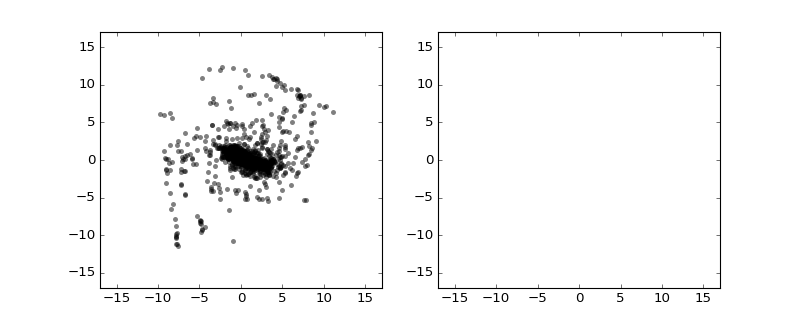

In [30]:
fig, ax = plt.subplots(1,2,figsize=[10,4])
ax[0].set_xlim([-17,17])
ax[0].set_ylim([-17,17])
ax[1].set_xlim([-17,17])
ax[1].set_ylim([-17,17])
ax[0].scatter(SF0.st.pos3d[sf0_id[0],0],SF0.st.pos3d[sf0_id[0],1],lw=0,c='k',alpha=0.5)


In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')

binnum = 51
con = (sf_info_age>-0.1)
bins = np.logspace(np.log10(sf_info_rho.min()),np.log10(sf_info_rho.max()),binnum)
hist,bins = np.histogram(sf_info_rho[con],bins=bins)
bin_center = (bins[:-1] + bins[1:])/2
bin_width = (bins[1:]-bins[:-1])
ax.bar(bin_center,hist,width=bin_width,alpha=0.5,color='g')
con = (sf_info_age<-0.1)&(sf_info_age>-0.2)
bins = np.logspace(np.log10(sf_info_rho.min()),np.log10(sf_info_rho.max()),binnum)
hist,bins = np.histogram(sf_info_rho[con],bins=bins)
bin_center = (bins[:-1] + bins[1:])/2
bin_width = (bins[1:]-bins[:-1])
ax.bar(bin_center,hist,width=bin_width,alpha=0.5,color='r')
con = (sf_info_age<-0.2)&(sf_info_age>-0.3)
bins = np.logspace(np.log10(sf_info_rho.min()),np.log10(sf_info_rho.max()),binnum)
hist,bins = np.histogram(sf_info_rho[con],bins=bins)
bin_center = (bins[:-1] + bins[1:])/2
bin_width = (bins[1:]-bins[:-1])
ax.bar(bin_center,hist,width=bin_width,alpha=0.5,color='b')

In [ ]:
alpha0    = (5.0*SF0.gs.sigma2)/(np.pi*myhalo.p.G*myhalo.gs.rho*myhalo.gs.hsml**2)
phi_t     = 0.49
theta     = 0.97
cs2       = (1/6.-1.0)*myhalo.gs.temp2
# Correct from polytrope
#cs2_poly  = (3000.)*(myhalo.gs.rho/1e-5)
#cs2       = cs2-cs2_poly



scrit     = np.log(0.067/(theta**2)*alpha0*(myhalo.gs.sigma2/cs2))


In [ ]:
print cs2
print myhalo.gs.sigma2

In [ ]:
gamma = 1.6
T2_star = 100.
scale_nH   = 0.76/ myhalo.p.mH * myhalo.p.unitd
nISM = 1e-5
#square sound speed
cs2 = (gamma-1.0)*myhalo.gs.temp#*myhalo.p.simutoKelvin
cs2_poly  = (T2_star)*(myhalo.gs.rho/nISM)

In [ ]:
print cs2


In [ ]:
%%latex
lets define stuff.

starting with $\vec{V}_{\alpha}$ and $D{\alpha}$ to be the velocity and the density of a side cell $C_{\alpha}$ while $\vec{v}$ and $\rho$ will be the velocity and density of the center cel. Each center cell has 6 side cells, therefore $\alpha=1..6$. Now we define the for a cell $\alpha$ the momentum conservation :
\begin{equation}
\vec{\Phi}_{\alpha}=\frac{D_{\alpha}\vec{V}_{\alpha}-\rho\vec{v}}{D_{\alpha}\rho}
\end{equation}

Now with $\vec{p}$ as the position vector of the center cell and $\vec{P}_{\alpha}$ as the position of the side cell $C_{\alpha}$. Then the vector conecting the center cell with $C_{\alpha}$ is $\vec{\delta}_{\alpha} = \vec{P}_{alpha}-\vec{p} $.
The two componentes of the the velocity disperssion is:

\begin{equation}
\sigma_{comp}^2=\sum_{\alpha<\beta} \frac{\vec{\delta}_{\alpha}.\vec{\delta}_{\beta}}{|\vec{\delta}_{\alpha}|^2|\vec{\delta}_{\beta}|}\left(\left(\vec{\Phi_{\alpha}}-\vec{\Phi_{\beta}}\right). \vec{\delta}_\alpha    \right)^2
\end{equation}
and 
\begin{equation}
\sigma_{sole}^2=\sum_{\alpha<\beta} \frac{\vec{\delta}_{\alpha}.\vec{\delta}_{\beta}}{|\vec{\delta}_{\alpha}|^2|\vec{\delta}_{\beta}|}
\left(\left(\vec{\Phi_{\alpha}}-\vec{\Phi_{\beta}}\right)\text{x}\, \vec{\delta}_\alpha    \right)^2
\end{equation}


In [ ]:
i=1310
J, K  = np.array([],dtype=int),np.array([],dtype=int)
for j in range(0,5):
        for k in range(j+1,6):
            J,K = np.append(J,int(j)),np.append(K,int(k))
print J
print K

def compute_sigma_comp(i):
    """
    equation 2
    """
    # vector from center cell to every cell
    delta = myhalo.gs.pos3d[:]-myhalo.gs.pos3d[i]
    Deltas = (delta[:,0]**2+delta[:,1]**2+delta[:,2]**2) 
    index = np.argsort(Deltas)[1:7]
    # vector from center cell to 6 side cell
    delta = delta[index]
    # modulus of these 6 vectors
    d_mod = np.array([np.linalg.norm(delta[l]) for l in range(len(delta))])
    # dd = 0 if two deltas are not alined and =1 if they are
    dd = (delta[J]*delta[K])[:,0]+(delta[J]*delta[K])[:,1]+(delta[J]*delta[K])[:,2]
    dd = np.abs(np.int0(-0.5+dd/d_mod[J]/d_mod[K]))
    # J are alphas in the equation 2 and K are betas only in the case wher dd==1
    j,k = J[(dd>0)],K[(dd>0)]
    rho,v = myhalo.gs.rho[i], myhalo.gs.vel3d[i]
    D, V = myhalo.gs.rho[index],myhalo.gs.vel3d[index]
    rho = np.array([rho for i in V])
    # Phi for 6 side cells
    Phi = np.transpose([(D*V[:,0]+(rho[0]*v[0]))/(D+rho),\
                        (D*V[:,1]+(rho[0]*v[1]))/(D+rho),\
                        (D*V[:,2]+(rho[0]*v[2]))/(D+rho)])
    # Phi substractions in the 3 cases where dd=1
    PmP = ((Phi[j]-Phi[k])*delta[j])**2
    PmP = (PmP[:,0]+PmP[:,1]+PmP[:,2])/ d_mod[j]**2
    sigma_comp = np.sum(PmP)
    return sigma_comp
get_sigma_comp = np.vectorize(compute_sigma_comp)

def compute_sigma_sole(i):
    """
    equation 3
    """
    # vector from center cell to every cell
    delta = myhalo.gs.pos3d[:]-myhalo.gs.pos3d[i]
    Deltas = (delta[:,0]**2+delta[:,1]**2+delta[:,2]**2) 
    index = np.argsort(Deltas)[1:7]
    # vector from center cell to 6 side cell
    delta = delta[index]
    # modulus of these 6 vectors
    d_mod = np.array([np.linalg.norm(delta[l]) for l in range(len(delta))])
    # dd = 0 if two deltas are not alined and =1 if they are
    dd = (delta[J]*delta[K])[:,0]+(delta[J]*delta[K])[:,1]+(delta[J]*delta[K])[:,2]
    dd = np.abs(np.int0(-0.2+dd/d_mod[J]/d_mod[K]))
    # J are alphas in the equation 2 and K are betas only in the case wher dd==1
    j,k = J[(dd>0)],K[(dd>0)]
    try:
        l = np.array([k[1],k[2],k[0],k[2],k[0],k[1]])
        j = np.reshape(np.transpose(np.stack([j,j])),[1,6])[0]
        k = np.reshape(np.transpose(np.stack([k,k])),[1,6])[0]
    except:
        return 0
    rho,v = myhalo.gs.rho[i], myhalo.gs.vel3d[i]
    D, V = myhalo.gs.rho[index],myhalo.gs.vel3d[index]
    rho = np.array([rho for i in V])
    # Phi for 6 side cells
    Phi = np.transpose([(D*V[:,0]+(rho[0]*v[0]))/(D+rho),\
                        (D*V[:,1]+(rho[0]*v[1]))/(D+rho),\
                        (D*V[:,2]+(rho[0]*v[2]))/(D+rho)])
    # Phi substractions in the 6 cases where dd=1
    PmP = ((Phi[j]-Phi[k])*delta[l])**2
    PmP = (PmP[:,0]+PmP[:,1]+PmP[:,2])/ d_mod[l]**2
    sigma_sole = np.sum(PmP)
    return sigma_sole

get_sigma_sole = np.vectorize(compute_sigma_sole)



def star_forming_cell_per_YS(i,sim):
    delta = sim.gs.pos3d[:]-sim.st.pos3d[i]
    Deltas = (delta[:,0]**2+delta[:,1]**2+delta[:,2]**2) 
    index = np.argsort(Deltas)[0]
    return index

get_sf_cell = np.vectorize(star_forming_cell_per_YS)

In [ ]:
myhalo.st.

In [ ]:
### get star forming cell ##
ma=-0.01
young = np.where(myhalo.st.age>ma)
a = datetime.datetime.now()
sf_cells_i = get_sf_cell(young,myhalo)
b = datetime.datetime.now()
print "this took {0}".format(b-a)
sf_cells_i = np.unique(sf_cells_i[0])


In [ ]:
### get star forming cell ##
youngSF0 = np.where(SF0.st.age>ma)
a = datetime.datetime.now()
sf_cells_iSF0 = get_sf_cell(youngSF0,SF0)
b = datetime.datetime.now()
print "this took {0}".format(b-a)
sf_cells_iSF0 = np.unique(sf_cells_iSF0[0])


In [ ]:
y_star = myhalo.st.age[myhalo.st.age>-0.005]
y_u, co = np.unique(y_star,return_counts=True)
y_u = y_u[np.argsort([y_u])][0]
co = co[np.argsort([y_u])][0]
print np.sum(co)


In [ ]:

young = np.where((myhalo.st.age>ma)&(myhalo.st.r<17))
fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,4])
ax.set_xlim([-19,19])
ax.set_ylim([-19,19])
ax.scatter(myhalo.st.pos3d[young,0],myhalo.st.pos3d[young,1],lw=0,s=2,label="young stars")
for i in sf_cells_i:
    hsml = myhalo.gs.hsml[i]
    llx, lly = myhalo.gs.pos3d[i,0]-hsml/2., myhalo.gs.pos3d[i,1]-hsml/2.
    rect = patches.Rectangle((llx,lly),hsml,hsml,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
ax.text(4,13,"Multi-freefall",fontsize=14)
ax1.text(6,13,"Classic SF",fontsize=14)    
ax1.set_xlim([-19,19])
ax1.set_ylim([-19,19])
ax1.scatter(SF0.st.pos3d[youngSF0,0],SF0.st.pos3d[youngSF0,1],lw=0,s=2,label="young stars")
for i in sf_cells_iSF0:
    hsml = SF0.gs.hsml[i]
    llx, lly = SF0.gs.pos3d[i,0]-hsml/2., SF0.gs.pos3d[i,1]-hsml/2.
    rect = patches.Rectangle((llx,lly),hsml,hsml,linewidth=1,edgecolor='r',facecolor='none')
    ax1.add_patch(rect)
ax.scatter(25,25,marker='s',color="r",facecolor="None", label="cells")  
ax1.scatter(25,25,marker='s',color="r",facecolor="None", label="cells")  
legend = ax1.legend(loc='lower right', ncol=3, shadow=False,
                    fontsize=12,frameon=False)
legend = ax.legend(loc='lower right', ncol=2, shadow=False,
                    fontsize=12,frameon=False)

In [ ]:
sf_rho = myhalo.gs.rho[sf_cells_i]
sf_rhoSF0 = SF0.gs.rho[sf_cells_iSF0]



In [ ]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,4])
ax.set_ylim([0,22])
ax1.set_ylim([0,22])
ax.set_xlim([1e6,3e10])
ax1.set_xlim([1e6,3e10])
ax.text(1.7e6,13,"Multi-freefall",fontsize=14)
ax1.text(1.7e6,13,"Classic SF",fontsize=14) 
ax.set_xscale('log')
ax.set_xlabel(r'$\rho_{sfcell}$ [M$_{\odot}$/kpc$^3$]',fontsize=15)
ax.set_ylabel(r'star forming cells',fontsize=15)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\rho_{sfcell}$ [M$_{\odot}$/kpc$^3$]',fontsize=15)
ax1.set_ylabel(r'star forming cells',fontsize=15)
binum =  60
bins = np.logspace(6,10.2,binum)
hist, bins = np.histogram(sf_rho,bins=bins)
bin_width = bins[1:]-bins[:-1]
bin_center = (bins[1:]+bins[:-1])/2.
ax.bar(bin_center,hist,width=bin_width)


bins = np.logspace(6,10.2,binum)
hist, bins = np.histogram(sf_rhoSF0,bins=bins)
bin_width = bins[1:]-bins[:-1]
bin_center = (bins[1:]+bins[:-1])/2.
ax1.bar(bin_center,hist,width=bin_width)
fig.tight_layout()

In [ ]:
## Get sigma comp
a = datetime.datetime.now()
sigma_comp = get_sigma_comp(sf_cells_i)
b = datetime.datetime.now()
print "this took {0}".format(b-a,len(myhalo.gs.rho))

In [ ]:
## Get sigma sole
a = datetime.datetime.now()
sigma_sole = get_sigma_sole(sf_cells_i)
b = datetime.datetime.now()
print "this took {0}".format(b-a,len(myhalo.gs.rho))

In [ ]:
print len(sigma_sole)
print len(sigma_comp)

In [ ]:
i=783826#young[0][45]
#def compute_sigma_sole(i):
#    """
#    equation 3
#    """
    # vector from center cell to every cell
delta = myhalo.gs.pos3d[:]-myhalo.gs.pos3d[i]
Deltas = (delta[:,0]**2+delta[:,1]**2+delta[:,2]**2) 
index = np.argsort(Deltas)[1:11]
# vector from center cell to 6 side cell
delta = delta[index]
# modulus of these 6 vectors
d_mod = np.array([np.linalg.norm(delta[l]) for l in range(len(delta))])
# dd = 0 if two deltas are not alined and =1 if they are
dd = (delta[J]*delta[K])[:,0]+(delta[J]*delta[K])[:,1]+(delta[J]*delta[K])[:,2]
print (dd/d_mod[J]/d_mod[K])
dd = np.abs(np.int0(-0.5+dd/d_mod[J]/d_mod[K]))
# J are alphas in the equation 2 and K are betas only in the case wher dd==1
print J
print K
print dd
j,k = J[(dd>0)],K[(dd>0)]
l = np.array([k[1],k[2],k[0],k[2],k[0],k[1]])
j = np.reshape(np.transpose(np.stack([j,j])),[1,6])[0]
k = np.reshape(np.transpose(np.stack([k,k])),[1,6])[0]

rho,v = myhalo.gs.rho[i], myhalo.gs.vel3d[i]
D, V = myhalo.gs.rho[index],myhalo.gs.vel3d[index]
rho = np.array([rho for i in V])
# Phi for 6 side cells
Phi = np.transpose([(D*V[:,0]+(rho[0]*v[0]))/(D+rho),\
                    (D*V[:,1]+(rho[0]*v[1]))/(D+rho),\
                    (D*V[:,2]+(rho[0]*v[2]))/(D+rho)])
# Phi substractions in the 6 cases where dd=1
PmP = ((Phi[j]-Phi[k])*delta[l])**2
PmP = (PmP[:,0]+PmP[:,1]+PmP[:,2])/ d_mod[j]**2
sigma_sole = np.sum(PmP)
print sigma_sole


In [ ]:
l = np.array([k[1],k[2],k[0],k[2],k[0],k[1]])

In [ ]:
np.int(1.1)

In [ ]:
nei = 6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(myhalo.gs.pos3d[i,0],myhalo.gs.pos3d[i,1],myhalo.gs.pos3d[i,2],s=30,c='r')
ax.scatter(myhalo.gs.pos3d[index][:,0],myhalo.gs.pos3d[index][:,1],myhalo.gs.pos3d[index][:,2],s=4)

In [145]:
#if np.mean(SF0.st.vphi)<0:
#SF0.gs.pos3d = SF0.gs.pos3d * [1,-1,-1]
#SF0.st.pos3d = SF0.st.pos3d * [1,-1,-1]
#SF0.dm.pos3d = SF0.dm.pos3d * [1,-1,-1]
ring = (np.abs(SF0.st.pos3d[:,2])<0.5)
ring = ring&(np.abs(SF0.st.pos3d[:,1])<0.5)
ring = ring&(SF0.st.pos3d[:,0]>7)&(SF0.st.pos3d[:,0]<9)
np.mean(SF0.st.vel3d[ring,1])

-53.27938

<IPython.core.display.Javascript object>


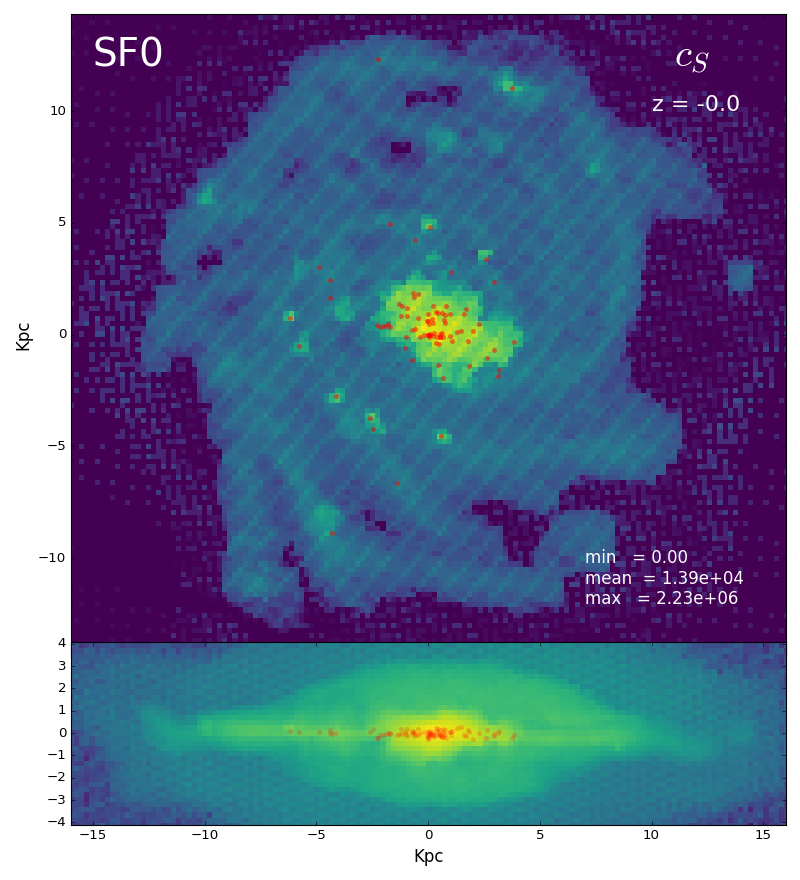

2226816.84375
6272498.277099609


In [138]:
#fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,5])
fig, [ax1,ax3] = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3.5, 1.]},figsize=[10,11],sharex=True)
length,thik=17,0.3
ax1.set_ylim([-(length-1),(length-1)]);ax1.set_xlim([-(length-1),(length-1)])


SF1140_faceOn,edges= face_on_gs_cs2(SF0,[-length,length],150,thikness=thik)#H.T 
print SF1140_faceOn.max()
mass_2 = ax1.imshow(SF1140_faceOn+1e-2, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=SF1140_faceOn.max())
                  )
ax1.text(-15,12,"SF0",fontsize=35,color='w')
texto =  "min   = {0:.2f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.2e}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.2e}".format(SF1140_faceOn.max())+'\n'
ax1.text(7,-13,texto,color='w',fontsize=15)
ax1.set_ylabel("Kpc",fontsize=15)
ax3.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= edge_on_gs_cs2(SF0,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax3.imshow(SF1140_faceOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=SF1140_faceOn.max())
                  )

age_lim = -0.005
                       
youngestSF0 = np.argsort(SF0.st.age)[-100:]
cutz = np.where(np.abs(SF0.st.pos3d[youngestSF0,2])<0.3)
ax1.text(11,12,r"$c_S$",fontsize=35,color='w')
ax1.text(10,10,"z = {0:.1f}".format(SF0.p.Z),color='w',fontsize=20)

ax1.scatter((SF0.st.pos3d[youngestSF0])[cutz,0],(SF0.st.pos3d[youngestSF0])[cutz,1],
            lw=0,c='r',alpha=0.5,s=20)
ax3.scatter((SF0.st.pos3d[youngestSF0])[cutz,0],(SF0.st.pos3d[youngestSF0])[cutz,2],
            lw=0,c='r',alpha=0.2,s=20)

fig.tight_layout(h_pad=-1)

In [129]:
ins = np.argsort(SF0.st.age)[-50:]
(SF0.st.pos3d[ins])[np.where(np.abs(SF0.st.pos3d[ins,2])<0.3),2]

array([[ 0.10348724, -0.22576287,  0.03879738,  0.06771609,  0.05104182,
         0.00272537, -0.0731488 , -0.13763652,  0.135795  , -0.1089071 ,
        -0.00445469, -0.00618   , -0.04576771, -0.09860904,  0.1267095 ,
        -0.09969942, -0.06860555, -0.13289313, -0.22882451, -0.08737901,
        -0.02010773,  0.06768124, -0.14471258,  0.05178195, -0.05565305,
        -0.16701407,  0.11537731, -0.10120955, -0.05778449, -0.22619536,
        -0.0956591 ,  0.07003214,  0.07873607, -0.14405995, -0.00152379,
         0.17949216, -0.01956782, -0.03682965,  0.01569412, -0.07744805,
        -0.02840623, -0.069543  ]])